In [23]:
from reinforce import ReinforceAgent, Categorical2D
from visualisation import draw_qap, draw_assignment_graph
from qap import GraphAssignmentProblem, AssignmentGraph
from torch_geometric.utils import from_networkx
import taskgenerators
import torch
from evaluate import random_assignment
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import networkx
import nn
from pathlib import Path
from ipywidgets import interact

In [24]:
with open("testgraph.qap", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

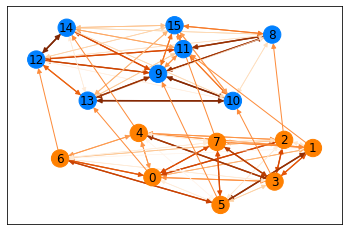

In [25]:
%matplotlib inline
draw_qap(qap, random_assignment(qap))

In [26]:
agents = []
path_prefix = Path("../runs/reinforce_nomessaging_baseline/")
for fname in sorted(path_prefix.glob("checkpoint_*.pth")):
    a = ReinforceAgent()
    a.load_checkpoint(fname)
    agents.append(a)

In [27]:
agent = agents[-1]
agent.solve_and_learn(qap)
for param in agent.networks.parameters():
    if param.grad is not None:
        print(torch.norm(param.grad))

tensor(0.0099)
tensor(0.0006)
tensor(0.0095)
tensor(0.0007)
tensor(0.0076)
tensor(0.0010)
tensor(0.0087)
tensor(0.0009)
tensor(0.0088)
tensor(0.0008)
tensor(0.0113)
tensor(0.0011)
tensor(0.0196)
tensor(0.0011)
tensor(0.0203)
tensor(1.0803e-07)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [28]:
def plot_embedding(ax, embedding):
    with torch.no_grad():
        ax.clear()
        ax.set_ylim(-1,1)
        ax.bar(range(len(embedding)), embedding)

def show_embeddings(embeddings):
    fig = plt.figure()
    ax = fig.gca()
    interact(lambda i: plot_embedding(ax, embeddings[i-1]), i=(1,len(embeddings)))
    fig.show()
    
def show_embeddings_series(embeddings_series):
    fig,ax = plt.subplots()
    interact(lambda i,j: plot_embedding(ax, embeddings_series[j-1][i-1]), 
             i=(1,len(embeddings_series[0])),
             j=(1,len(embeddings_series))
            )
    fig.show()

<IPython.core.display.Javascript object>


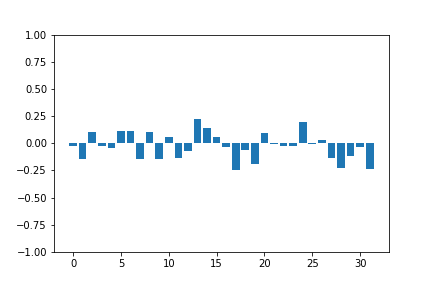

interactive(children=(IntSlider(value=4, description='i', max=8, min=1), IntSlider(value=6, description='j', m…

In [29]:
%matplotlib notebook
# Node embeddings
start_graph_a_by_epoch = []
start_graph_b_by_epoch = []
for agent in agents:
    start_graph_a_by_epoch.append(agent.transform_initial_graph(qap.graph_source))
    start_graph_b_by_epoch.append(agent.transform_initial_graph(qap.graph_target))
node_embedding_by_epoch = [data.x for data in start_graph_a_by_epoch]
show_embeddings_series(node_embedding_by_epoch)

In [21]:
%matplotlib notebook

def plot_matrix(ax, matrix, **kwargs):
    with torch.no_grad():
        ax.imshow(matrix, **kwargs)

def show_matrix_series(series, **kwargs):
    fig = plt.figure()
    ax = fig.gca()
    interact(lambda i: plot_matrix(ax, series[i-1], **kwargs), 
             i=(1,len(series)),
            )
    fig.show()

<IPython.core.display.Javascript object>


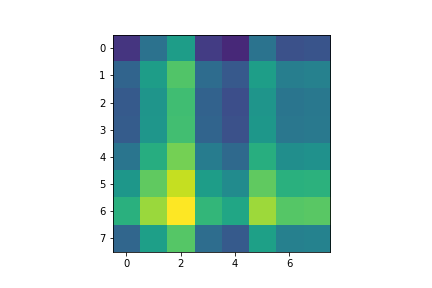

interactive(children=(IntSlider(value=6, description='i', max=11, min=1), Output()), _dom_classes=('widget-int…

In [30]:
%matplotlib notebook
# Probability matrices
probs_by_epoch = torch.stack([
    agent.compute_link_probabilities(start_graph_a_by_epoch[i].x, start_graph_b_by_epoch[i].x)
    for i, agent in enumerate(agents)
])

show_matrix_series(probs_by_epoch, vmin=torch.min(probs_by_epoch), vmax=torch.max(probs_by_epoch))

<IPython.core.display.Javascript object>


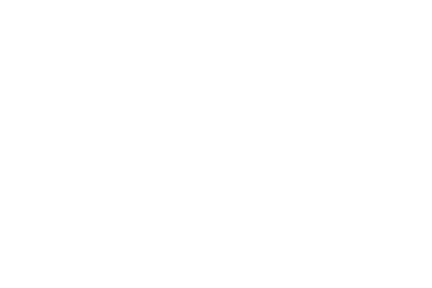

interactive(children=(IntSlider(value=6, description='i', max=11, min=1), Output()), _dom_classes=('widget-int…

In [10]:
%matplotlib notebook
show_matrix_series(node_embedding_by_epoch)

In [11]:
def print_parameter_gradients(x):
    agent.optimizer.zero_grad(set_to_none=True)
    x.backward(retain_graph=True)
    for param in agent.networks.parameters():
        if param.grad is not None:
            print(torch.norm(param.grad))

In [12]:
#print_parameter_gradients(probabilities[5,3])

In [13]:
#agent.link_freeze_net(torch.cat((embeddings_a[0], embeddings_b[1])))

In [14]:
from nn import FullyConnected, NodeTransformer, cartesian_product_matrix, concat_bidirectional, sum_incoming_edges, dense_edge_features_to_sparse
# networkx graph to connectivity matrix
connectivity_matrix = torch.tensor(networkx.linalg.adjacency_matrix(qap.graph_source).todense()).float()
# compute edge embedding vectors from weight values
edge_embeddings = nn.edge_histogram_embeddings(connectivity_matrix, agent.edge_embedding_size)
# aggregate edges and compute initial node embeddings
aggregated = sum_incoming_edges(edge_embeddings)
base_embeddings = agent.initial_node_embedding_net(aggregated)

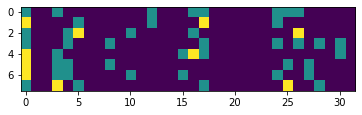

In [15]:
%matplotlib inline
plot_matrix(plt, aggregated)

In [16]:
t1 = torch.tensor([[1,2,3],[4,5,6]])
t2 = torch.tensor([[7,8,9],[0,-1,-3]])

In [17]:
nn.cartesian_product_matrix(t1,t2)

tensor([[[ 1,  2,  3,  7,  8,  9],
         [ 1,  2,  3,  0, -1, -3]],

        [[ 4,  5,  6,  7,  8,  9],
         [ 4,  5,  6,  0, -1, -3]]])

In [18]:
baselines = [agent.baseline.mean() for agent in agents]

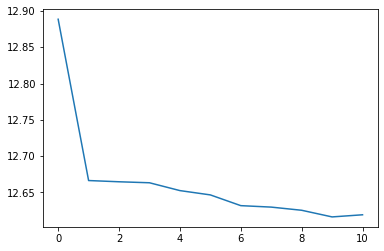

In [19]:
%matplotlib inline
plt.plot(baselines)
plt.show()